In [44]:
from weibopy import WeiboOauth2, WeiboClient
import webbrowser

In [45]:
client_key = '4256855957' # 你的 app key
client_secret = '3033c441bc9e09704e02e5d25268c7fe' # 你的 app secret
redirect_url = 'https://api.weibo.com/oauth2/default.html'

##### 获取微博访问权限
>Access Token 是为了避免多次调用 API 时需要重复输入用户名和密码的一种设计。
>
>程序登录后获得 Access Token，使用 Access Token 就能在一定时间内免密码使用平台的功能。

In [46]:
auth = WeiboOauth2(client_key, client_secret, redirect_url)
# 获取认证 code
webbrowser.open_new(auth.authorize_url)
# 在打开的浏览器中完成操作
# 最终会跳转到一个显示 「微博 OAuth2.0」字样的页面
# 从这个页面的 URL 中复制 code= 后的字符串
# URL 类似这样 https://api.weibo.com/oauth2/default.html?code=9c88ff5051d273522700a6b0261f21e6
code = input('输入 code:')
# 使用 code 获取 token
token = auth.auth_access(code)
print(token)

输入 code:566b6bf3f8bdf6571d24f3597b99139f
{'access_token': '2.009alOXGDh1FeEe253bb0a4aH4EPOC', 'remind_in': '157679998', 'expires_in': 157679998, 'uid': '5987935600', 'isRealName': 'true'}


##### 调用 API 接口获取数据
>微博 id 很容易获得，只要打开一条微博，查看页面的 URL，比如 https://m.weibo.cn/detail/4321877356979717
，后面的那串数字就是这条微博的 id。
>
>上面的代码将获取到 id 为 4318237070487349 的微博的前 200 条评论内容，并且已经存储为字典形式。

In [47]:
# token 是刚刚获得的 token，可以一直使用
client = WeiboClient(token['access_token'])
# suffix 指定 API 的名称，parmas 是参数，在文档中有详细描述
result = client.get(suffix='comments/show.json', params={'id': 4329351808137767, 'count': 200, 'page': 1})
print(result)

{'comments': [{'created_at': 'Fri Jan 18 12:35:20 +0800 2019', 'id': 4329791165269117, 'rootid': 4329791165269117, 'floor_number': 3067, 'text': '[拳头]', 'disable_reply': 0, 'user': {'id': 5747770998, 'idstr': '5747770998', 'class': 1, 'screen_name': '一颗奶糖·', 'name': '一颗奶糖·', 'province': '400', 'city': '1', 'location': '海外 美国', 'description': '人生建议，喜欢我', 'url': '', 'profile_image_url': 'http://tvax2.sinaimg.cn/crop.0.0.200.200.50/006gZ3NQly8fyrfdu8ndxj305k05kwg5.jpg', 'cover_image_phone': 'http://ww1.sinaimg.cn/crop.0.0.640.640.640/9d44112bjw1f1xl1c10tuj20hs0hs0tw.jpg', 'profile_url': 'u/5747770998', 'domain': '', 'weihao': '', 'gender': 'f', 'followers_count': 5066, 'friends_count': 265, 'pagefriends_count': 19, 'statuses_count': 125, 'video_status_count': 0, 'favourites_count': 512, 'created_at': 'Sat Oct 31 00:01:34 +0800 2015', 'following': False, 'allow_all_act_msg': False, 'geo_enabled': True, 'verified': False, 'verified_type': -1, 'remark': '', 'insecurity': {'sexual_content': F

##### 整理所需数据
>阅读 API 文档中可以发现，comments/show 除了返回评论本身外，还返回了许多额外的数据。有了这些数据，你能够创造更多玩法。
>
>评论信息：

  - 创建时间、内容、来源

>
>评论者信息：

  - 用户昵称、性别、注册时间
  - 用户的省市信息
  - 用户个人描述、博客地址、头像、域名
  - 用户的粉丝数、关注数、微博数、收藏数

>下面我们将结合 评论的内容的情感倾向 和 评论者的地理位置 这两个维度数据，进行整理和可视化展示。

##### 评论内容预处理
>首先，评论包含一些对情感分析无用的干扰内容，比如：`回复@某某某：`
>
>利用正则表达式去除上述的干扰内容;
>
>接下来，按地域划分评论内容;

In [48]:
from collections import defaultdict
import time,re

province_list = defaultdict(list) # 保存按省划分的评论正文
comment_text_list = [] # 保存所有评论正文

# 获取「自杀式单身」评论列表
# 共获取 10 页 * 每页最多 200 条评论
for i in range(1, 11):
    result = client.get(suffix='comments/show.json', params={'id': 4322140368509204, 'count': 200, 'page': i})

    comments = result['comments']
    if not len(comments):
        break

    for comment in comments:
        text = re.sub('回复.*?:', '', str(comment['text']))
        province = comment['user']['province']
        province_list[province].append(text)
        comment_text_list.append(text)

    print('已抓取评论 {} 条'.format(len(comment_text_list)))
    time.sleep(1)

已抓取评论 194 条
已抓取评论 380 条
已抓取评论 574 条
已抓取评论 766 条
已抓取评论 957 条
已抓取评论 1148 条
已抓取评论 1340 条
已抓取评论 1526 条
已抓取评论 1715 条
已抓取评论 1911 条


##### 文本情感分析
使用 snownlp 库可以对文本进行情感分析，它会对每个文本生成一个 0-1 的得分，数值越大，是积极情绪的概率越高。
>情感分析的原理其实很简单：提取一句话中的一些关键词，判断每个关键词对应情感为积极的概率，最后取最大值

由于我们获取的为省份 id 。需要将其转换为对应名称以便绘图。需访问 相应 API 获取 id 和 名称的映射：

In [49]:
# 获取省份列表
provinces = {}
results = client.get(suffix='common/get_province.json', params={'country': '001'})
for prov in results:
    for code, name in prov.items():
        provinces[code] = name
print(provinces)

{'001011': '北京', '001012': '天津', '001013': '河北', '001014': '山西', '001015': '内蒙古', '001021': '辽宁', '001022': '吉林', '001023': '黑龙江', '001031': '上海', '001032': '江苏', '001033': '浙江', '001034': '安徽', '001035': '福建', '001036': '江西', '001037': '山东', '001041': '河南', '001042': '湖北', '001043': '湖南', '001044': '广东', '001045': '广西', '001046': '海南', '001050': '重庆', '001051': '四川', '001052': '贵州', '001053': '云南', '001054': '西藏', '001061': '陕西', '001062': '甘肃', '001063': '青海', '001064': '宁夏', '001065': '新疆', '001071': '台湾', '001081': '香港', '001082': '澳门'}


In [50]:
from snownlp import SnowNLP

In [51]:
# 评论情感分析
positives = {}
for province_code, comments in province_list.items():
    sentiment_list = []
    for text in comments:
        s = SnowNLP(text)
        sentiment_list.append(s.sentiments)

    # 统计平均情感
    positive_number = sum(sentiment_list)
    positive = positive_number / len(sentiment_list) * 100

    # 按省保存数据, 0010 为国家前缀
    province_code = '0010' + str(province_code)
    if province_code in provinces:
        provice_name = provinces[province_code]
        positives[provice_name] = int(positive)

##### 绘制地图

In [53]:
from pyecharts import Map

In [54]:
# 绘制情感分布图
keys = list(positives.keys())
values = list(positives.values())
map = Map("自杀式单身 情感分析地域图", width=1200, height=600)
map.add("积极情感", keys, values, visual_range=[0, 100], maptype='china', is_visualmap=True, is_label_show=True, visual_text_color='#000')
map.render(path="单身热评分布.html")

##### 表情统计

In [56]:
from collections import Counter

# 获取评论中出现的表情
emoji_list = []
for comment in comment_text_list:
    emojis = re.findall(re.compile(u'(\[.*?\])', re.S), comment)
    if emojis:
        for emoji in emojis:
            emoji_list.append(emoji)
emoji_dict = Counter(emoji_list)

print(emoji_dict)

Counter({'[微笑]': 64, '[给力]': 46, '[good]': 25, '[允悲]': 21, '[汗]': 18, '[鼓掌]': 14, '[二哈]': 12, '[怒]': 12, '[挖鼻]': 12, '[吃瓜]': 11, '[黑线]': 10, '[泪]': 9, '[哼]': 9, '[思考]': 9, '[加油]': 8, '[doge]': 8, '[喵喵]': 7, '[嘻嘻]': 7, '[摊手]': 7, '[并不简单]': 7, '[赞啊]': 7, '[太开心]': 6, '[笑cry]': 6, '[拜拜]': 5, '[吃惊]': 5, '[哈哈]': 4, '[赞]': 4, '[馋嘴]': 4, '[可爱]': 4, '[偷笑]': 3, '[微风]': 3, '[拳頭]': 3, '[太阳]': 3, '[睡]': 3, '[跪了]': 2, '[骷髅]': 2, '[笑而不语]': 2, '[疑问]': 1, '[污]': 1, '[酷]': 1, '[傻眼]': 1, '[伤心]': 1, '[衰]': 1, '[熊猫]': 1, '[互粉]': 1, '[ok]': 1, '[可怜]': 1, '[吐]': 1, '[拳头]': 1, '[猪头]': 1, '[顶]': 1, '[米奇比心]': 1, '[中国赞]': 1, '[悲伤]': 1, '[耶]': 1, '[嘘]': 1, '[失望]': 1, '[哆啦A梦微笑]': 1})


In [58]:
import pandas as pd

In [85]:
keys = []
values = []
for item in emoji_dict:
    key = re.sub('[\[\]]','',str(item))
    value = emoji_dict[item]
    keys.append(key)
    values.append(value)

In [90]:
c={"key" : keys,
   "value" : values}
emoji_pd = pd.DataFrame(c) 

In [93]:
emoji_pd.head()

,key,value
0,疑问,1
1,偷笑,3
2,微笑,64
3,喵喵,7
4,二哈,12


##### 学习绘制词云

>英文词云直接用就可以，但是中午词云要先用分词将其以空格分开，才能绘制词云

>此外值得注意的是，中文词云一定一定要加一个font_path

In [38]:
import jieba

In [40]:
from wordcloud import WordCloud
filename = 'test.txt'
with open(filename) as f:
    mytext = f.read()
font_path = 'fonts\simkai.ttf'

In [41]:
mytext = " ".join(jieba.cut(mytext))
mytext

'蓝鲸 TMT 频道 1 与 18 日讯 ， 小米 集团 发布公告 称 ， 经 董事会 正式 决议 决定 ， 按 市场 上 每股 B股 股份 9.7625 港元 的 价格 回购 614 万股 B 类 股份 。 \n 小米 董事会 认为 ， 于 现况 下 进行 股份 购回 可 展示 公司 对 自身 业务 展望 及 前景 充满信心 ， 且 最终 会为 公司 带来 裨益 及 为 股东 创造 价值 ， 公司 现有 财务 资源 足以 支持 股份 购回 同时 维持 稳健 的 财务状况 。 \n 小米 方面 称 ， 在 互联网 商业模式 及 公司 “ 智能手机 ＋ AIoT 双引擎 ” 策略 的 推动 下 ， 公司 以 股份 回购 表达 对 现时 及 长期 业务 前景 充满信心 。 \n 1 月 9 日 ， 小米 集团 部分 机构 持股 解禁 ， 小米 集团 于 当日 发布公告 称 ， 公司 创始人 、 董事长 兼 CEO 雷军 ， 基于 对 公司 长期 价值 的 坚定信心 ， 承诺 一年 之内 不会 出售 其 持有 的 股票 。 \n 1 月 16 日 ， 有 媒体报道 称 ， 小米 上市 前 股东 解禁 后 ， 连环 被 主要 股东 抛货 ， 继 俄罗斯 基金 披露 日前 减持 近 6 亿股 后 ， 再 被 机构 股东 以 折让 最多 6.8% 配售 逾 2 亿股 ， 套现 最多 22 亿元 。 \n 据 彭博 报道 ， 在 6 个 月 禁售 期 解禁 后 ， 有 未 披露 的 投资者 以 每股 9.45 港元 的 价格 出售 了 2.31 亿股 B 类股票 。 \n 如今 ， 资本 市场 对 小米 股价 波动 颇为 关切 。 \n 1 月 17 日 ， 小米 收盘价 为 9.74 港元 ， 比起 2018 年 7 月 创下 的 最高 位 22.2 港元 ， 小米 的 股价 下跌 已超 50% ， 市值 蒸发 近 3000 亿港元 。 与 小米 发行价 17 港元 / 股 相比 ， 小米 上市 仅 半年 内 跌幅 已超 39% 。'

In [42]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2,font_path=font_path).generate(mytext)

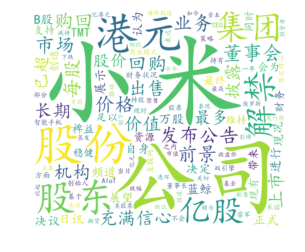

In [43]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
wordcloud.to_file('test.png')

##### 表情Dataframe转为词云

>与上面词云不同的是，这个是利用dataframe中的key和value即词频进行绘制

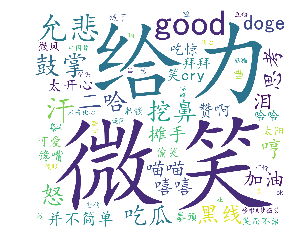

In [103]:
wordcloud = WordCloud(background_color="white",width=1000, height=860, margin=2,font_path=font_path)
words = emoji_pd.set_index('key').to_dict()  # 设置segment列为索引，并将DataFrame转化为字典形式
wordcloud.fit_words(words['value'])  # 配置词云
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [104]:
wordcloud.to_file('emoji.png')